# Get Latest Sensor Data from CARE API

In [ ]:
from dotenv import load_dotenv
import os
import requests

load_dotenv(override=True)

schema = os.environ["SCHEMA"]
table_name = os.environ["TABLE_NAME"]

url = f"https://sync.upcare.ph/api/sensorinsights/{schema}/{table_name}/latest"

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)

In [128]:
pm25 = [x['pm25'] for x in response.json()]
pm25 = [0 if x is None else x for x in pm25]
latitude = [x['gps_lat'] for x in response.json()]
longitude = [x['gps_long'] for x in response.json()]

In [129]:
import numpy as np

# Define the grid for interpolation
gridx = np.linspace(min(longitude) -.01, max(longitude) +.01, 100)
gridy = np.linspace(min(latitude) -.01, max(latitude) + .01, 100)

# Kriging Model

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'linear' Variogram Model
Slope: 114.4377010513429
Nugget: 0.6113068628958757 



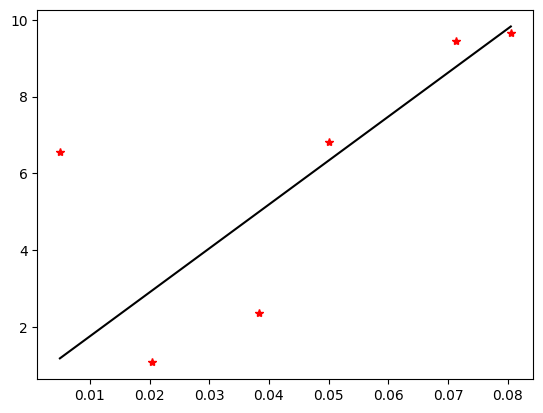

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [130]:
from pykrige.ok import OrdinaryKriging

OK = OrdinaryKriging(longitude, 
                     latitude, 
                     pm25, 
                     variogram_model='linear', 
                     coordinates_type='geographic', 
                     verbose=True, 
                     enable_plotting=True)
z_interp, ss = OK.execute('grid', gridx, gridy) 

# Visualize Model

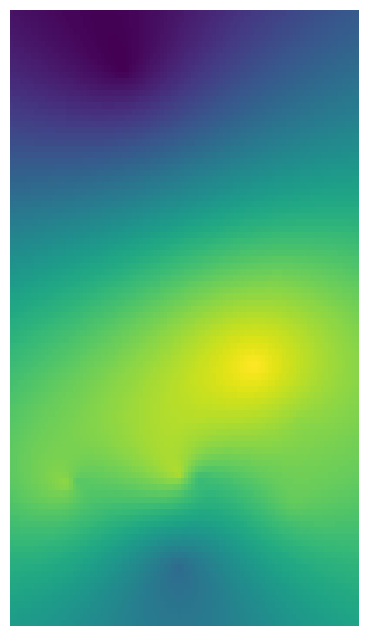

In [131]:
import matplotlib.pyplot as plt
from PIL import Image
# import matplotlib.colors as mcolors

# Assuming z_interp, gridx, and gridy are already defined

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# cmap = mcolors.ListedColormap(['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#99004c', '#7e0023'])

# Plot the interpolation results
cax = ax.imshow(z_interp, 
                extent=[gridx.min(), 
                        gridx.max(), 
                        gridy.min(), 
                        gridy.max()], 
                origin='lower', 
                cmap='viridis_r', 
                alpha=1)


# # Add color bar
# cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
# cbar.set_label('AQI Value')

# Remove axes
ax.axis('off')

# Save the image
fig.savefig('kriging.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

# Load the image with PIL
image = Image.open('kriging.png')

fig



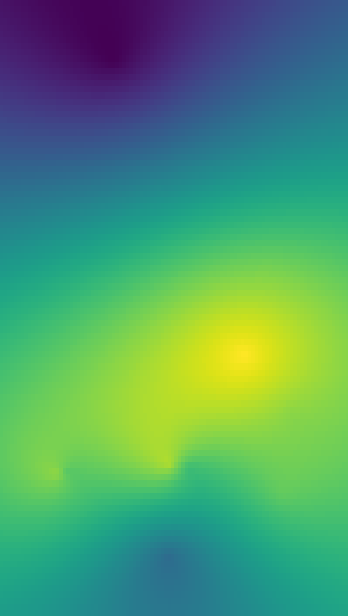

In [ ]:
import folium
from folium.raster_layers import ImageOverlay

# Create a base map centered on Metro Manila
# m = folium.Map(location=[29.76, -95.37],tiles="Cartodb Positron", zoom_start=10)
m = folium.Map(location=[gridy.max(), gridx.min()], zoom_start=14)

# Define the bounds where the image will be placed
bounds = [[gridy.min(), gridx.min()], [gridy.max(), gridx.max()]]

# Add the image overlay
image_overlay = ImageOverlay(
    image='kriging.png',
    bounds=bounds,
    opacity=.7,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

image_overlay.add_to(m)

# Add points for the measuring stations
for lat, lon in zip(latitude, longitude):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1
    ).add_to(m)

# Save the map to an HTML file
m.save('map.html')

# Display the map
m
